In [27]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [28]:
stock_name = "AAPL"

df = yf.download(stock_name, start="2000-01-01", end=dt.datetime.now().strftime("%Y-%m-%d"))
df

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2000-01-03 00:00:00+00:00,0.843077,0.999442,1.004464,0.907924,0.936384,535796800
2000-01-04 00:00:00+00:00,0.771997,0.915179,0.987723,0.903460,0.966518,512377600
2000-01-05 00:00:00+00:00,0.783293,0.928571,0.987165,0.919643,0.926339,778321600
2000-01-06 00:00:00+00:00,0.715508,0.848214,0.955357,0.848214,0.947545,767972800
2000-01-07 00:00:00+00:00,0.749401,0.888393,0.901786,0.852679,0.861607,460734400
...,...,...,...,...,...,...
2024-12-24 00:00:00+00:00,258.200012,258.200012,258.209991,255.289993,255.490005,23234700
2024-12-26 00:00:00+00:00,259.019989,259.019989,260.100006,257.630005,258.190002,27237100


In [29]:
df_close = df["Close"]
df_close

Ticker,AAPL
Date,
2000-01-03 00:00:00+00:00,0.999442
2000-01-04 00:00:00+00:00,0.915179
2000-01-05 00:00:00+00:00,0.928571
2000-01-06 00:00:00+00:00,0.848214
2000-01-07 00:00:00+00:00,0.888393
...,...
2024-12-24 00:00:00+00:00,258.200012
2024-12-26 00:00:00+00:00,259.019989
2024-12-27 00:00:00+00:00,255.589996


<Axes: xlabel='Date'>

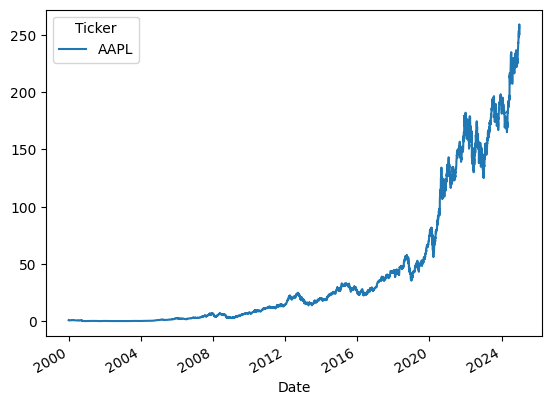

In [30]:
df_close.plot()

In [31]:
## generate data by window with target 
def window_data(data, window_size):
    X = []
    y = []
    
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
        
    return np.array(X), np.array(y).reshape(-1, 1)

df_windowed, df_target = window_data(df_close.to_numpy(), 6)
scaler = MinMaxScaler()
# Reshape df_windowed to 2D
df_windowed_reshaped = df_windowed.reshape(df_windowed.shape[0], -1)
df_windowed_reshaped = scaler.fit_transform(df_windowed_reshaped)
# Reshape back to 3D
df_windowed = df_windowed_reshaped.reshape(df_windowed.shape[0], df_windowed.shape[1], df_windowed.shape[2])
df_target = scaler.fit_transform(df_target)
train_size = int(0.9 * len(df_windowed))
X_train = df_windowed[:train_size]
y_train = df_target[:train_size]
X_test = df_windowed[train_size:]
y_test = df_target[train_size:]



In [32]:
model_lstm = Sequential([
    LSTM(units=64, 
            return_sequences=True, 
            input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    
    LSTM(units=64),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(1)
])
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')
model_lstm.summary()

c:\Users\Dell Latitude 5420\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0045
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9719e-04
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3104e-04
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1680e-04
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6404e-04
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9160e-04
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6032e-04
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7209e-04
Epoch 9/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2239e-04
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9715e-04
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3002e-04
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0135e-04
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2380e-04
Epoch 14/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


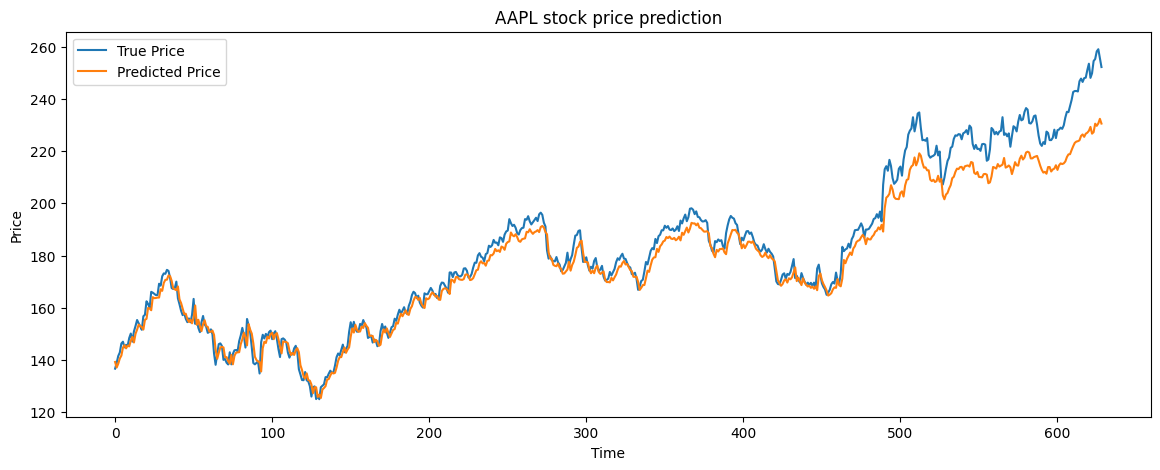

In [34]:
X_pred = model_lstm.predict(X_test)
X_pred = scaler.inverse_transform(X_pred)
y_test = scaler.inverse_transform(y_test)

plt.figure(figsize=(14, 5))
plt.plot(y_test, label='True Price')
plt.plot(X_pred, label='Predicted Price')
plt.title(f'{stock_name} stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

[*********************100%***********************]  1 of 1 completed
c:\Users\Dell Latitude 5420\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 6, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0182 - val_loss: 8.8258e-04
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0747e-04 - val_loss: 0.0033
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3265e-04 - val_loss: 0.0016
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5795e-04 - val_loss: 0.0010
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5483e-04 - val_loss: 2.5823e-04
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1233e-04 - val_loss: 4.1708e-04
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2982e-04 - val_loss: 0.0015
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0069e-04 - val_loss: 2.2452e-04
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5749e-04 - val_loss: 4.3148e-04
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8491e-04 - val_loss: 4.5068e-04
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3293e-04 - val_loss: 0.001

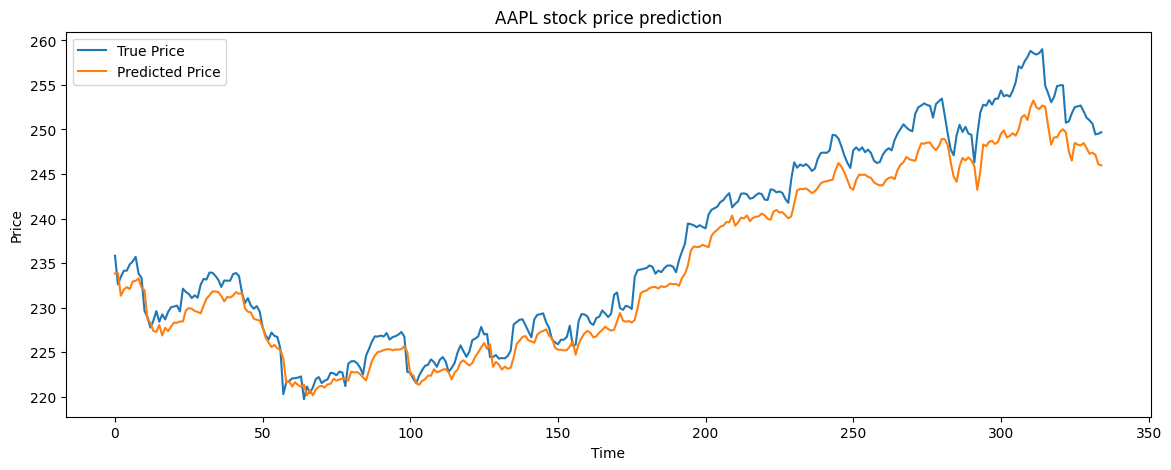

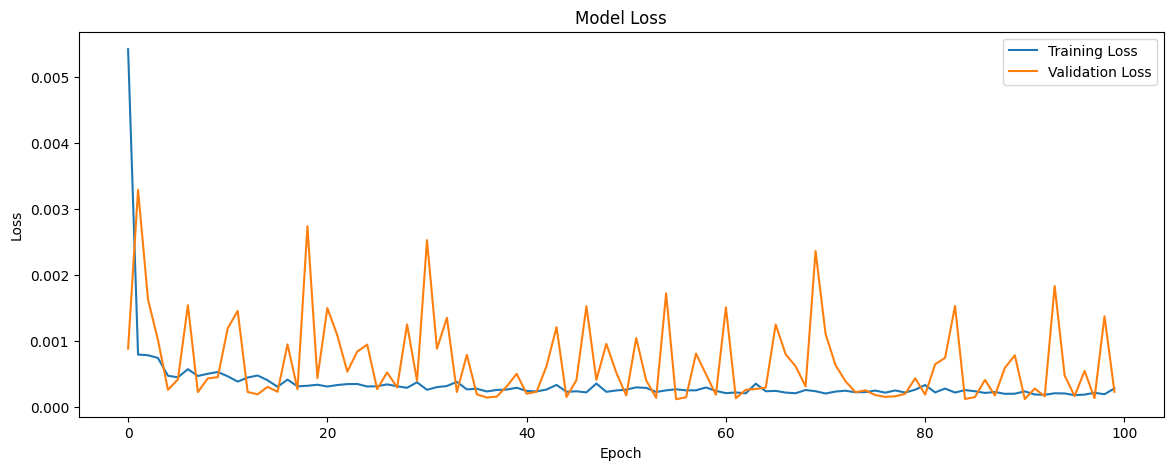

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

df = yf.download(stock_name, start="2023-02-01", end=dt.datetime.now().strftime("%Y-%m-%d"),interval='1h')
# print(df)
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df.columns = cols
def window_data_multivariate(data, window_size):
    """
    Generate windowed data using multiple features to predict closing price
    
    Parameters:
    data (numpy array): Input data of shape (n_samples, n_features)
    window_size (int): Number of time steps to look back
    
    Returns:
    X (numpy array): Input windows of shape (n_samples, window_size, n_features)
    y (numpy array): Target closing prices of shape (n_samples, 1)
    """
    X = []
    y = []
    
    for i in range(len(data) - window_size - 1):
        # Window includes all features
        X.append(data[i:(i + window_size), :])
        # Target is next day's closing price
        y.append(data[i + window_size, 0])  # Closing price is first column
        
    return np.array(X), np.array(y).reshape(-1, 1)

# Prepare feature DataFrame - adjust these columns based on your available data
df_features = df[['Close', 'High', 'Low', 'Volume']].copy()

# Scale all features
scaler_features = MinMaxScaler()
df_scaled = scaler_features.fit_transform(df_features)

# Create separate scaler for closing price (target)
scaler_target = MinMaxScaler()
scaler_target.fit(df_features['Close'].values.reshape(-1, 1))

# Generate windowed data
df_windowed, df_target = window_data_multivariate(df_scaled, window_size=6)
# print(df_windowed)

# Split into train and test sets
train_size = int(0.9 * len(df_windowed))
X_train = df_windowed[:train_size]
y_train = df_target[:train_size]
X_test = df_windowed[train_size:]
y_test = df_target[train_size:]

# Create and compile the model
model_lstm = Sequential([
    LSTM(units=64, 
         return_sequences=True, 
         input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    
    LSTM(units=64),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')
model_lstm.summary()

# Train the model
history = model_lstm.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    verbose=1
)

# Make predictions
X_pred = model_lstm.predict(X_test)

# Inverse transform predictions and actual values
# We can directly use scaler_target since we're only dealing with closing prices
y_pred = scaler_target.inverse_transform(X_pred)
y_test_transformed = scaler_target.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(y_test_transformed, label='True Price')
plt.plot(y_pred, label='Predicted Price')
plt.title(f'{stock_name} stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-02-01 14:30:00+00:00,142.960007,142.960007,143.869995,142.589996,143.860001,11912462
2023-02-01 15:30:00+00:00,142.910004,142.910004,143.274994,142.330002,142.970001,7542626
2023-02-01 16:30:00+00:00,141.960007,141.960007,143.005005,141.720001,142.910004,6492856
2023-02-01 17:30:00+00:00,142.009995,142.009995,142.270004,141.839996,141.951706,4542380
2023-02-01 18:30:00+00:00,142.389999,142.389999,143.190002,141.520004,142.020004,7713862
...,...,...,...,...,...,...
2024-12-31 16:30:00+00:00,250.716293,250.716293,251.550003,250.649994,251.179993,1975317
2024-12-31 17:30:00+00:00,249.690002,249.690002,250.759995,249.440002,250.699997,3894785
2024-12-31 18:30:00+00:00,249.770004,249.770004,250.268005,249.529999,249.690002,2272071


In [37]:
# forecast for the next day 
df_forecast = df_features.iloc[-6:].copy()
df_forecast_scaled = scaler_features.transform(df_forecast)
X_forecast = df_forecast_scaled.reshape(1, df_forecast_scaled.shape[0], df_forecast_scaled.shape[1])
y_forecast = model_lstm.predict(X_forecast)
y_forecast = scaler_target.inverse_transform(y_forecast)
y_forecast



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[245.75049]], dtype=float32)

In [38]:
from alpha_vantage.timeseries import TimeSeries

# Your Alpha Vantage API key
api_key = "A0RLHRH54US1BGNV"

# Initialize TimeSeries
ts = TimeSeries(key=api_key, output_format='pandas')

# Get real-time stock data for 'AAPL'
data, meta_data = ts.get_intraday(symbol='AAPL', interval='1min', outputsize='compact')

# Print the latest data
print(data.head())


                      1. open  2. high  3. low  4. close  5. volume
date                                                               
2024-12-31 19:59:00  250.4100   250.45  250.41    250.45      192.0
2024-12-31 19:58:00  250.4200   250.47  250.41    250.43      545.0
2024-12-31 19:57:00  250.4292   250.43  250.41    250.42       59.0
2024-12-31 19:56:00  250.4250   250.43  250.41    250.42       38.0
2024-12-31 19:55:00  250.4200   250.43  250.41    250.42       91.0


In [39]:
import yfinance as yf

# Check if the market is open
ticker = yf.Ticker("AAPL")
is_open = ticker.info.get("marketState")
print(f"Market state: {is_open}")

Market state: None
